### Link to your presentation video here

# Problem Statement
## FIFA 20
Football is arguably the most popular sport in the world and FIFA is the most popular football (soccer) simulation game by Electronic Arts (EA Sports). 

The game is not to be confused with the official International Federation for Football (FIFA).

You are given the following public dataset, scraped from https://sofifa.com. The data lists soccer players from the 2015-2020 editions of EA Sports FIFA video game. It consists of player positions, player attributes and personal data.


## Problem 
The player club changes can be tracked using the unique Sofifa id across all years. The problem statement is as follows: 

## Part A - Rank the Players      
    | Who is the best player in the world according to your analysis?
- Use data from FIFA 19. Predict the Overall (OVR ) skill Statistic for players in the FIFA 20 Edition. Train on all players from FIFA 19

- Graphically represent the Overall data for the players in test set (see below)

### Instructions : 
- Sofifa Id, URL, Name, Potential, Real face, URL variables cannot be used during the prediction or learning. 

- In case of a change in playing position, alter FIFA 20 position to match FIFA 19 Position 

- The final score will be assigned using MSE. 

- Test Set: Players from the following Clubs 

  - FC Barcelona

  - FC Bayern München

  - Real Madrid 

  - Paris Saint-Germain

  - Juventus

  - Manchester City

  - Liverpool FC

----------------------------------------------------------------------------------------------------------------

### Importing all the necessary libraries

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#custom function
from preprocess import preprocess
%matplotlib inline

pd.set_option('display.max_columns', 100)

### Load the dataset

In [2]:
fifa_19 = pd.read_csv('data/players_19.csv')

unique_players = fifa_19.sofifa_id.nunique()
print("Total number of unique players:", unique_players)

fifa_19.head()

Total number of unique players: 17770


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,94,94,77000000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,127100000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Diver, Flair, Long Shot Taker...",84,94,89,81,87,88,...,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,94,94,110500000,565000,"CF, RW, ST",Left,5,4,4,Medium/Medium,Messi,Yes,226500000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",RW,10.0,NaN,2004-07-01,2021.0,CF,10.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (CPU AI Only), S...",77,95,70,90,86,97,...,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,93,118500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,228100000.0,"#Speedster, #Dribbler, #FK Specialist, #Acroba...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Diver, Selfish, Flair, Speed Dribbler (CPU AI ...",79,87,62,84,84,96,...,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,91,93,72000000,260000,GK,Right,4,3,1,Medium/Medium,Lean,Yes,138600000.0,NaN,GK,1.0,NaN,2011-07-01,2019.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,"GK Long Throw, Saves with Feet",17,13,21,50,13,18,...,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,91,92,102000000,355000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,196400000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,N

# Exploratory Data Analysis

**We visualize the dataset to get a better idea of what the predictors look like and if they reveal patterns, corrleations, null values and imbalance in the dataset. Anything to help us better clean the data and make good inferences**

In [63]:
# calculate correlation of all features with respect to 'Overall'
corr = fifa_19.corr()["overall"].sort_values(ascending=False)

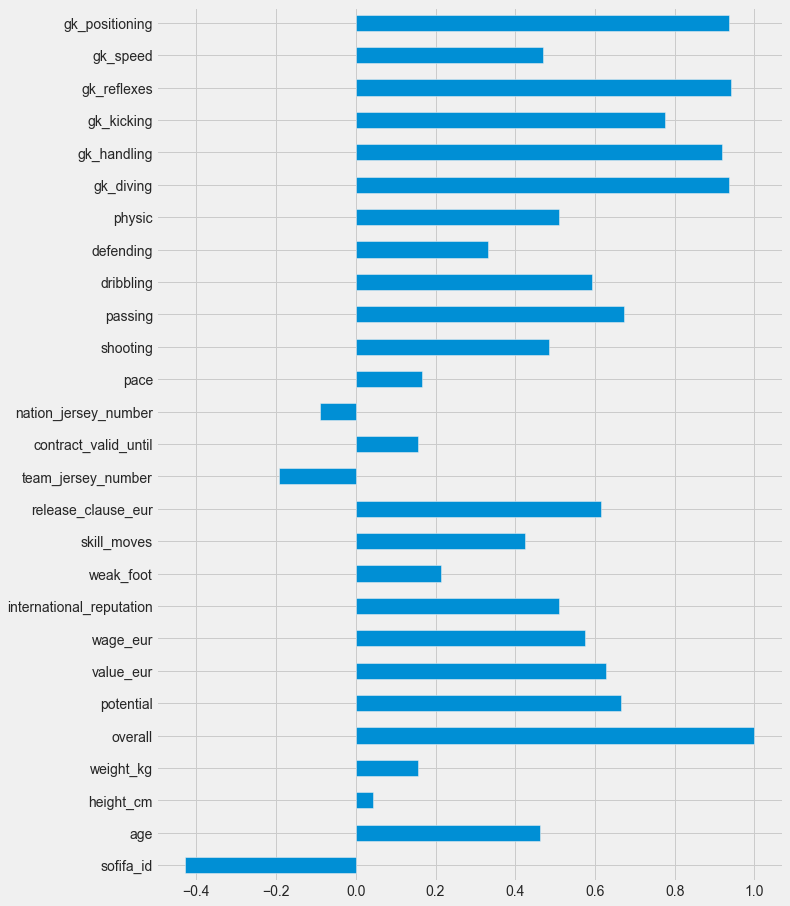

In [64]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 15))
fifa_19.corr()['overall'].plot.barh()
plt.show()

**Some predictors show suprious correlation with our response variable "Overall". For example, the sofifa_id, a predictor that has no relation with the response variable shows a neagtive correlation. While discarding this might seem obvious in this scenario (because it is an ID and the problem statement also hints at it), it is not always easy to identify such predictors without computing their correlation measure.** 

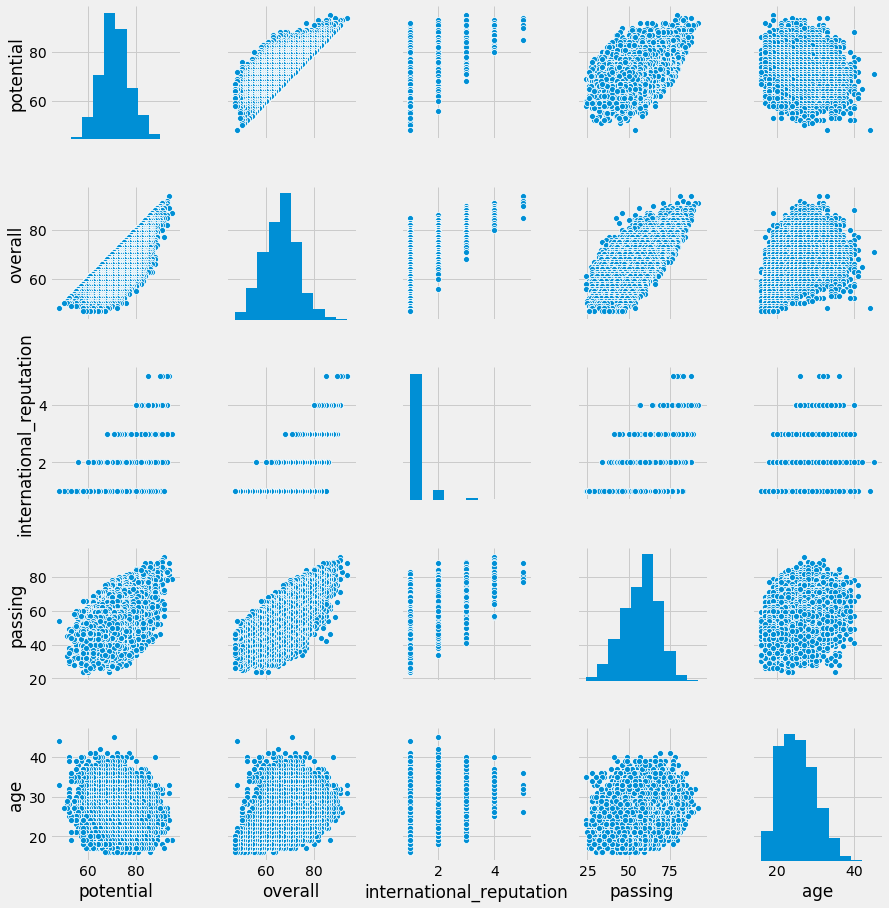

In [5]:
cols = fifa_19[['potential', 'overall', 'international_reputation', 'passing', 'age']]   
sns.pairplot(cols)
plt.show()

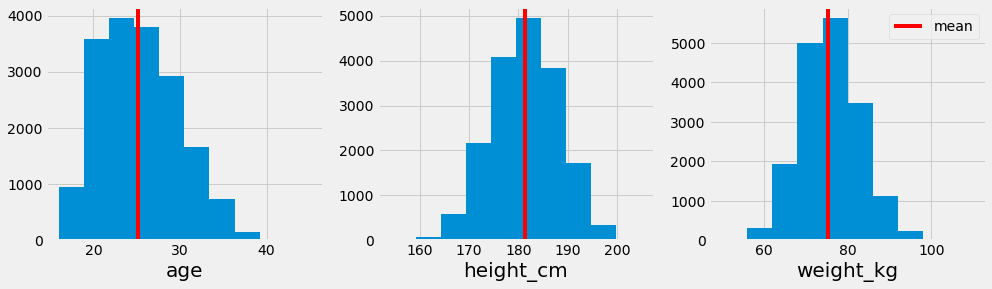

In [8]:
cols = ['age', 'height_cm', 'weight_kg']
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(cols):
    ax[i].hist(fifa_19[col])
    ax[i].set_xlabel(col, fontsize=20)
    ax[i].axvline(fifa_19[col].mean(),color='red', label="mean")
plt.legend()
plt.show()

**It can also be helpful to look at the age demographics and other such details to get an idea about how the data is collected (to look for possible biases) or in this case, that the data is faithful to its observations.** 

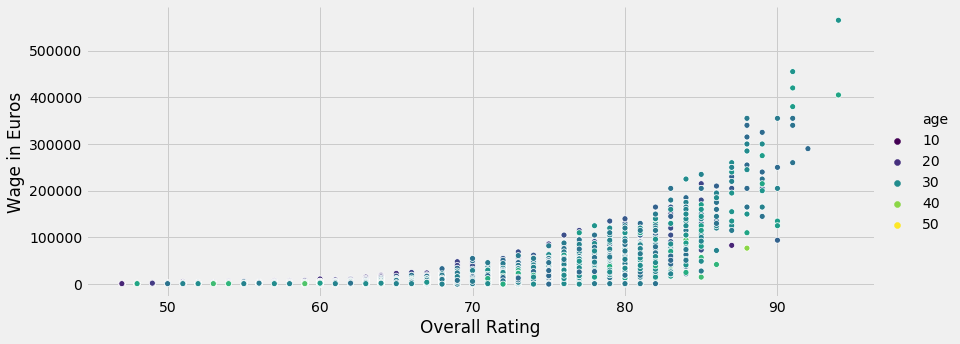

In [39]:
# wage_eur vs overall
sns.relplot(x='overall',y='wage_eur',hue='age',palette = 'viridis', sizes=(15, 200),aspect=2.5,data=fifa_19)
plt.xlabel('Overall Rating')
plt.ylabel('Wage in Euros')
plt.show()

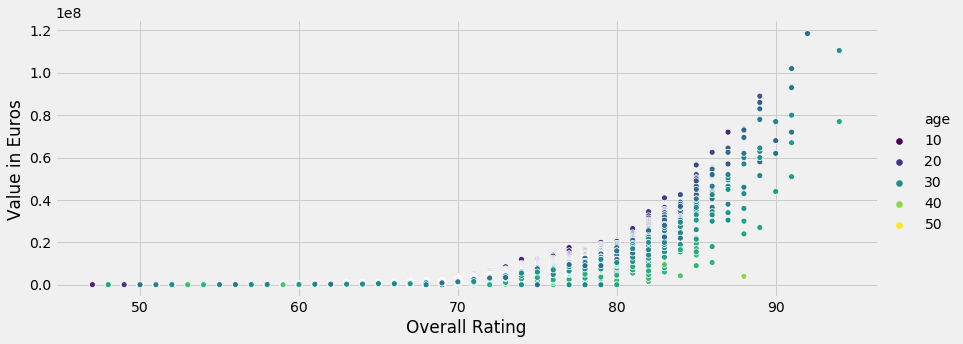

In [9]:
sns.relplot(x='overall',y='value_eur',hue='age',palette = 'viridis', sizes=(15, 200),aspect=2.5,data=fifa_19)
plt.xlabel('Overall Rating')to
plt.ylabel('Value in Euros')
plt.show()


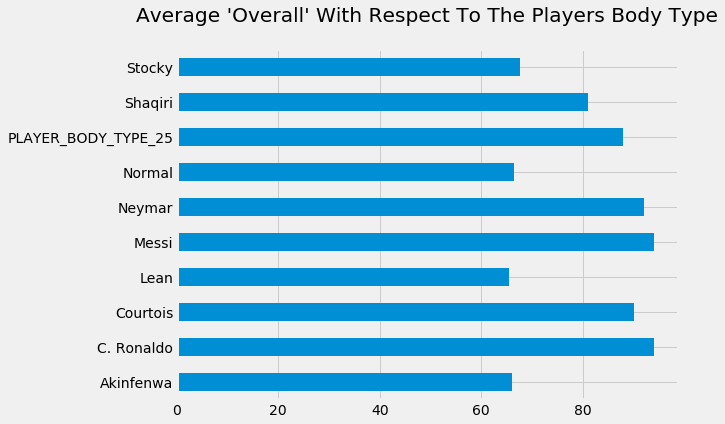

In [55]:
# average overall with respect to body type
plt.figure(figsize=(8, 6))
fifa_19.groupby('body_type')['overall'].mean().plot.barh()
plt.ylabel('')
plt.title("Average 'Overall' With Respect To The Players Body Type\n")
# plt.savefig('body_type.pdf', bbox_inches='tight', transparent=True)
plt.show()

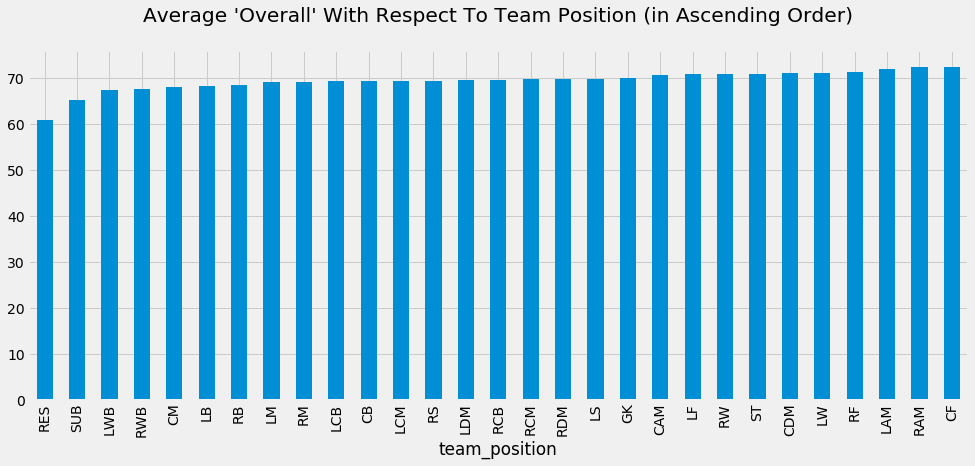

In [51]:
# average overall with respect to team_position
plt.figure(figsize=(15, 6))
fifa_19.groupby('team_position')['overall'].mean().sort_values().plot.bar()
plt.title("Average 'Overall' With Respect To Team Position (in Ascending Order)\n")
# plt.savefig('team_position.pdf', bbox_inches='tight', transparent=True)
plt.show()

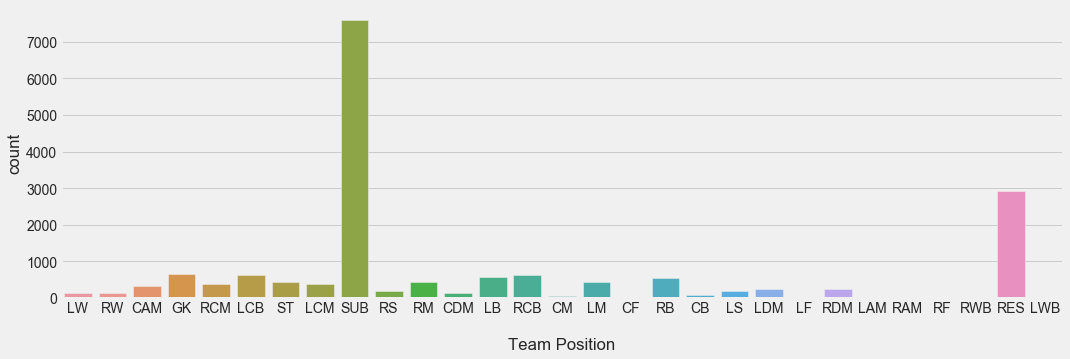

In [65]:
plt.figure(figsize=(16, 5))
sns.countplot(fifa_19.team_position)
plt.xlabel("\nTeam Position")
# plt.savefig('team_position_count.pdf', bbox_inches='tight', transparent=True)
plt.show()

**In the following plots we look at the top players and see how well they rank given their clubs, nationality, reputation and see which team positions do the top 100 players hold.**

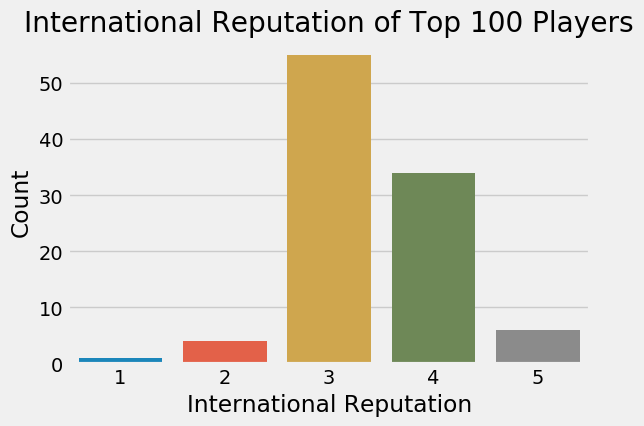

In [10]:
# sns.set_style('white')
plt.figure(dpi=100)
sns.countplot('international_reputation',data=fifa_19.head(100))
plt.xlabel('International Reputation')
plt.ylabel('Count')
plt.title('International Reputation of Top 100 Players')
plt.show()

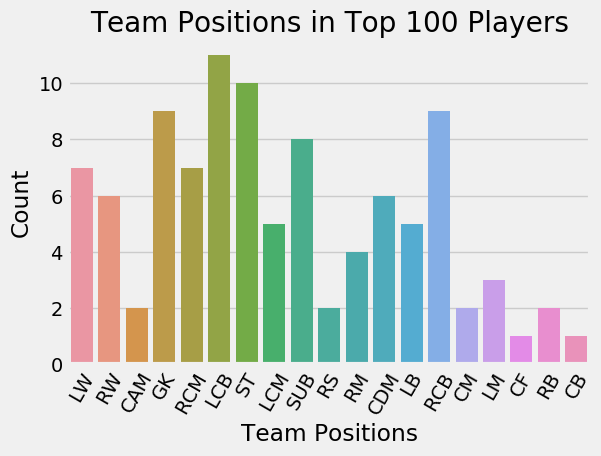

In [11]:
plt.figure(dpi=100)
sns.countplot('team_position',data=fifa_19.head(100))
plt.xlabel('Team Positions')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.title('Team Positions in Top 100 Players')
plt.show()

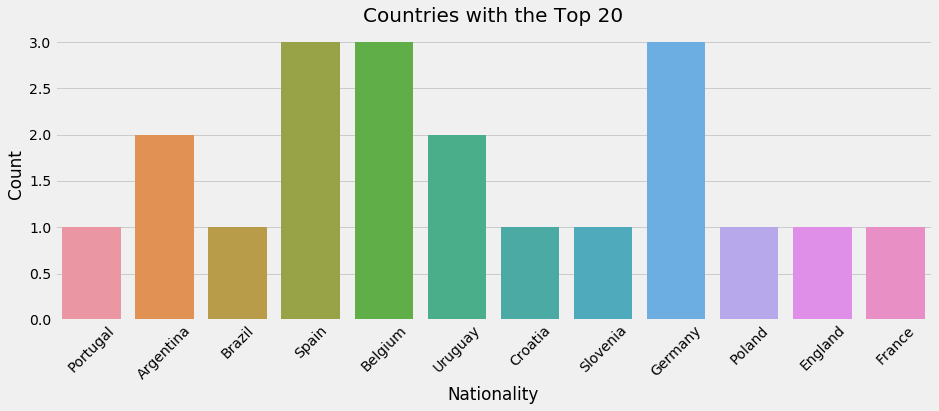

In [12]:
plt.figure(figsize=(14,5))
sns.countplot('nationality',data=fifa_19.head(20))
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Countries with the Top 20',fontsize = 20)
plt.show()

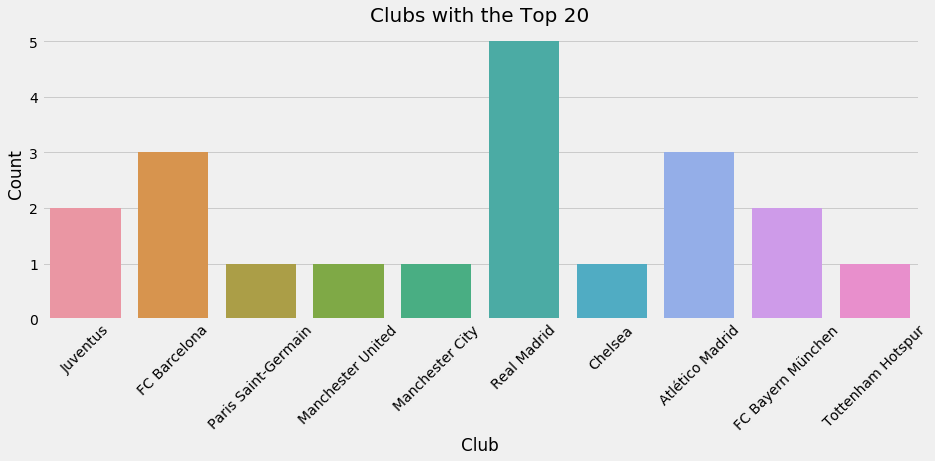

In [13]:
plt.figure(figsize=(14,5))
sns.countplot('club',data=fifa_19.head(20))
plt.xlabel('Club')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Clubs with the Top 20',fontsize = 20)
plt.show()

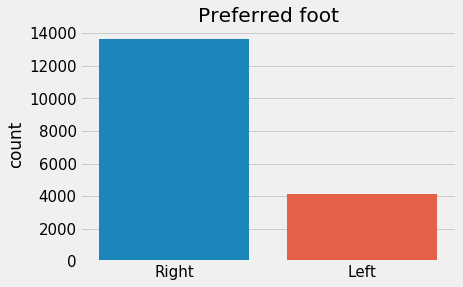

In [14]:
# count number of players by preferred foot
sns.countplot(fifa_19.preferred_foot)
plt.title("Preferred foot")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

**Could this predictor make a difference in the our predictions? We can check for such imbalanced data and see its influence on our training set by including and excluding such predictors.**

# Preprocess: Data Cleaning & Handling Missing Values

**We created a function 'preprocess.py' to reduce clutter in the notebook. The function drops predictors such as sofifa_id, potential, loaned_from, team_positions, nation_postions, player_traits and a few more, in order to avoid either predictors that offer no valuable information, result in too many variable upon one hot encoding, or contain one too many null values. It also takes care of missing values in other predictors using Simple Imputer from sklearn. The code also makes sure that for predictors such as 'lm', 'lf', 'rf' etc, the null values are filled in with the mode of the distribution of that variable.**

In [15]:
# preprocess is a custom function that will drop all the unnecessary columns and 
# fills the missing values using appropriate strategy
fifa_19_prerpocessed = preprocess(fifa_19)

In [16]:
fifa_19_prerpocessed.head()

,age,height_cm,weight_kg,overall,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,33,187,83,94,77000000,405000,Right,5,4,5,High/Low,127100000.0,2022.0,90.000000,93.000000,81.000000,89.000000,35.000000,79.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61
1,31,170,72,94,110500000,565000,Left,5,4,4,Medium/Medium,226500000.0,2021.0,88.000000,91.000000,88.000000,96.000000,32.000000,61.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58
2,26,175,68,92,118500000,290000,Right,5,5,5,High/Medium,228100000.0,2022.0,92.000000,84.000000,83.000000,95.000000,32.000000,59.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60
3,27,193,76,91,72000000,260000,Right,4,3,1,Medium/Medium,138600000.0,2019.0,67.815319,52.248733,57.082172,62.267169,51.665484,64.972567,90.000000,85.000000,87.000000,94.000000,58.00000,88.000000,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,60,60,60,63,61,61,61,63,62,62,62,61,60,60,60,61,59,62,62,62,59,61,63,63,63,61
4,27,181,70,91,102000000,355000,Right,4,5,4,High/High,196400000.0,2023.0,77.000000,86.000000,92.000000,87.000000,60.000000,78.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73


In [17]:
# OneHotEncode Categorical Variables
fifa_dummies = pd.get_dummies(fifa_19_prerpocessed, drop_first=True)
# print the shape
fifa_dummies.shape

(17770, 92)

## Split into training and testing data

In [18]:
# copy the onehotencoded dataframe
fifa_final = fifa_dummies.copy()
# separate the predictors and response variables
X = fifa_final.drop('overall', axis=1)
y = fifa_final.overall

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14216, 91), (3554, 91), (14216,), (3554,))

# Train Different Models

**Using:**
**1. Linear Regression**
**2. KNN Regression**
**3. Random Forest**

**We also define two functions called 'display' and 'train and evaluate' to reduce the number of code lines and also to avoid confusion amongst ourselves when running several models.**



In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def display(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std:", scores.std())

In [20]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model_scores = {}
    
    # cross-validation
    scores = cross_val_score(model, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
    scores = -(scores)
    mean_score = scores.mean()
    std = scores.std()
    model_scores["mean"] = f"{mean_score:.2f}"
    model_scores['standard_deviation'] = f"{std:.2f}"
    return model_scores

In [36]:
# creating an object of three different models
lreg = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor(n_estimators=233)

lreg_score = train_and_evaluate(lreg, X_train_sc, y_train, X_test_sc, y_test)
knn_score = train_and_evaluate(knn, X_train_sc, y_train, X_test_sc, y_test)
rf_score = train_and_evaluate(rf, X_train_sc, y_train, X_test_sc, y_test)

scores = [lreg_score, knn_score, rf_score]

In [37]:
scores_df = pd.DataFrame(scores, index =["Linear Regression", "KNeighbors Regressor", "Random Forest Regressor"])
scores_df.columns = ["MSE", "STD"]
scores_df

,MSE,STD
Linear Regression,4.44,0.12
KNeighbors Regressor,3.41,0.14
Random Forest Regressor,0.41,0.05


**We have a clear winner with Random Forest which is better at handling predictors which are linear and non linear, continuous and discrete all thanks to the decision trees they use.**

# Training Random Forest Model On Whole Dataset

**While several of the Random Forest can be hyper tuned to get the best set of parameters to fit on our test data, we decided against it as we realised it was beyond the scope of this project and that we didn't have sufficient knowldege of this algorithm in order to choose which values for the arguments are best suited for RandomForestRegressor function.**

In [38]:
fifa_final = fifa_dummies.copy()
X = fifa_final.drop('overall', axis=1)
y = fifa_final.overall

# scale the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestRegressor(n_estimators=233)
rf.fit(X_scaled, y)

RandomForestRegressor(n_estimators=233)

In [39]:
# saving the trained model
joblib.dump(rf,'best_rf.h5')

['best_rf.h5']

**We have finally arrived at our best model and we can now use it on our test data**

## Predict on 2020 Fifa Dataset

In [22]:
# load fifa 2020 dataset
fifa_2020 = pd.read_csv('data/players_20.csv')

# filter out the clubs which will be used for prediction
clubs = ['FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 'Manchester City', 'Liverpool']

# preprocess the data
fifa_20_cleaned = preprocess(fifa_2020, True)

# assign categorical columns to be one hot encoded
OneHotCols = ['preferred_foot', 'work_rate']

# OneHotEncode categorical columns
final_dummies = pd.get_dummies(fifa_20_cleaned, columns=OneHotCols, drop_first=True)

# only keep necessary rows
def func(se):
    if se in clubs:
        return True
    return False 

final_dummies['mask'] = final_dummies.club.apply(func)
final_test = final_dummies[final_dummies['mask']]

In [23]:
# separate predictor and response. 
X_test = final_test.drop(['overall', 'club', 'mask', 'short_name'], axis=1)
y_test = final_test.overall

# scale the X_test
X_test_scaled = scaler.transform(X_test)

In [24]:
# load model
model = joblib.load('best_rf.h5')
# make prediction using the trained model
final_preds = model.predict(X_test_scaled)
# print mean squared error
print("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, final_preds)))

Mean Squared Error: 0.507


In [25]:
# Create a dataframe using necessary columns that will be used for visualizaiton
df = final_test[['club', 'overall', 'short_name']].copy()

# # add prediction to the dataframe
df['prediction'] = final_preds

# # sort the datafame in descending order by predictions
df_sorted = df.sort_values(by='prediction', ascending=False)

# # print top 5 predicted players
df.head()

,club,overall,short_name,prediction
0,FC Barcelona,94,L. Messi,92.918455
1,Juventus,93,Cristiano Ronaldo,91.793991
2,Paris Saint-Germain,92,Neymar Jr,91.171674
4,Real Madrid,91,E. Hazard,90.866953
5,Manchester City,91,K. De Bruyne,90.510730


**Messi makes it to the top (at least according to our data and model)**

UsageError: Line magic function `%plt.savefig("club_top_20.pdf",` not found.


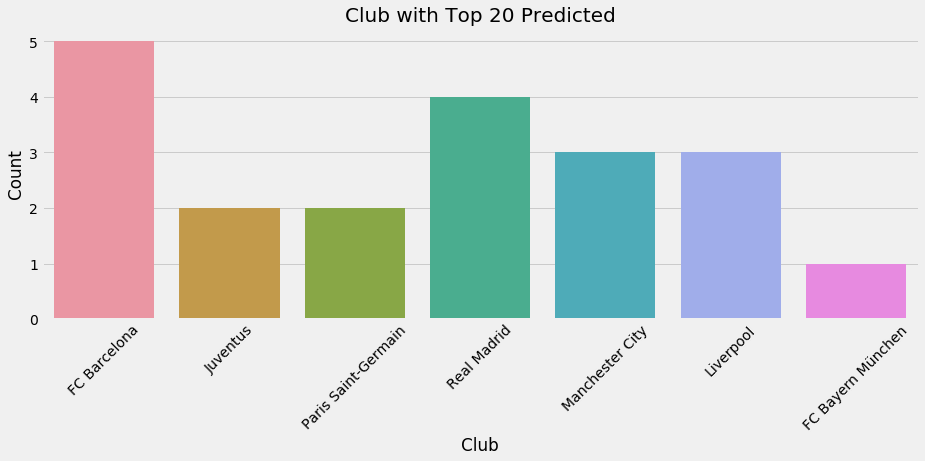

In [26]:
plt.figure(figsize=(14,5))
sns.countplot('club',data=df_sorted.head(20))
plt.xlabel('Club')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Club with Top 20 Predicted',fontsize = 20)
# plt.savefig("club_top_20.pdf", bbox_inches='tight', transparent=True)
plt.show()

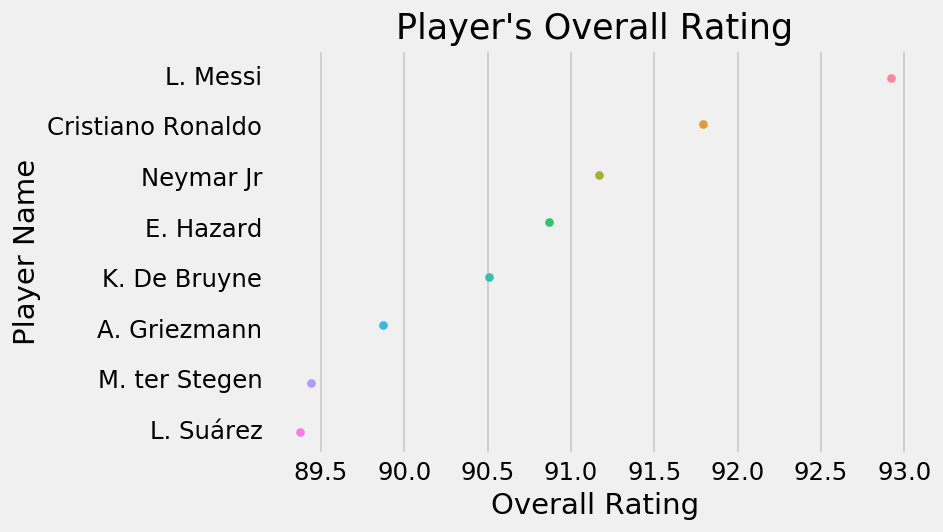

In [27]:
#testing this plot with that below for better visuals
plt.figure(dpi=125)
sns.stripplot(x = df_sorted.head(8)['prediction'], y = df_sorted.head(8)['short_name'], data = df_sorted.head(8))
plt.xlabel('Overall Rating')
plt.ylabel('Player Name')
plt.title('Player\'s Overall Rating')
plt.show()

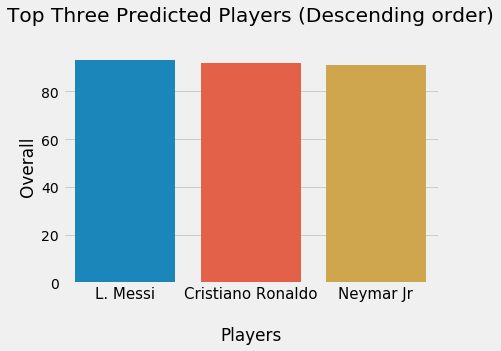

In [29]:
# Top three predict players. Either this or above
plt.style.use('fivethirtyeight')
ax = sns.barplot(df_sorted.head(3)['short_name'], df_sorted.head(3)['prediction'])
ax.set_title("Top Three Predicted Players (Descending order)\n")
ax.set_ylabel("Overall")
ax.set_xlabel("\nPlayers")
plt.xticks(fontsize=15)
#plt.savefig('top3.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [30]:
# get top 10 predicted scores
top_10_predictions = df_sorted.iloc[:10, 3].values
# get first 10 actual scores 
actual = df_sorted.iloc[:10, 1].values
# get the names of the first 10 players
top_10_players = df_sorted.iloc[:10, 2].values

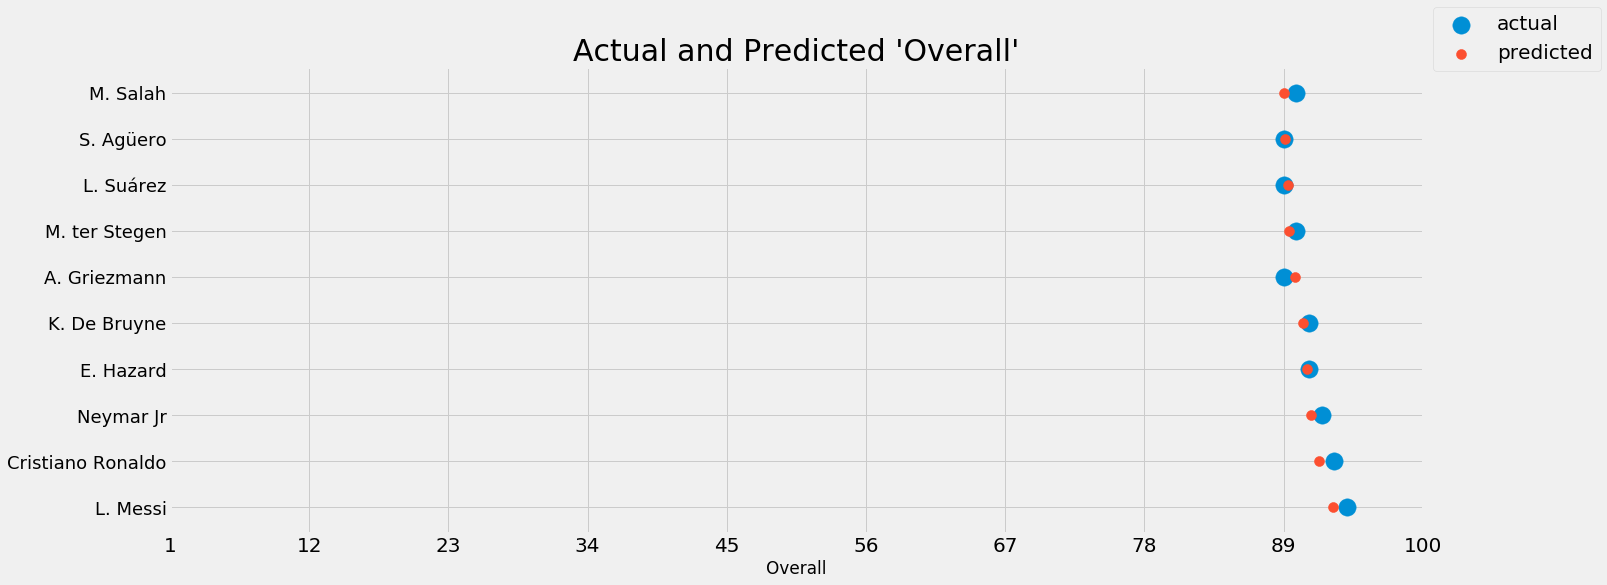

In [31]:
# create xticks for side-by-side bar plot. Changed y and x axis to see if it looks better
xticks1 = np.arange(10)
xticks2 = xticks1+0.4

plt.style.use('fivethirtyeight')
# plot
plt.figure(figsize=(20, 8))
plt.scatter(actual,xticks1, label="actual", s=300)
plt.scatter(top_10_predictions, xticks1, label="predicted", s=100)
plt.yticks(xticks1, top_10_players, fontsize=18)
plt.xticks(np.linspace(1, 100, 10), fontsize=20)
plt.title("Actual and Predicted 'Overall'", fontsize=30)
plt.xlabel("Overall")
plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1.15))
plt.show()

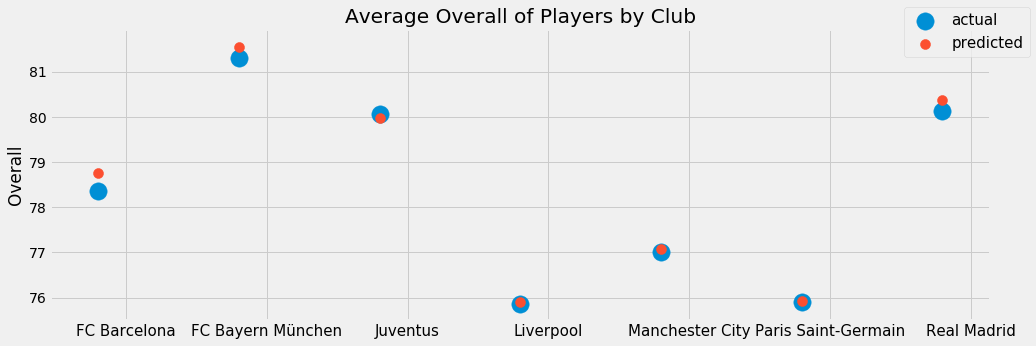

In [32]:
ax = df.groupby('club')['overall'].mean()
ax1 = df.groupby('club')['prediction'].mean()
# plot
plt.figure(figsize=(15, 5))
plt.scatter([1, 1.5, 2, 2.5, 3, 3.5, 4], ax.values, label="actual", s=300)
plt.scatter([1, 1.5, 2, 2.5, 3, 3.5, 4], ax1.values, label="predicted", s=100)
plt.xticks([1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1], labels=list(ax.index), fontsize=15)
plt.ylabel("Overall")
plt.title("Average Overall of Players by Club")
plt.legend(bbox_to_anchor=(0.9, 1.1), loc='upper left', fontsize=15)
#plt.savefig("club.pdf", bbox_inches='tight', transparent=True)
plt.show()

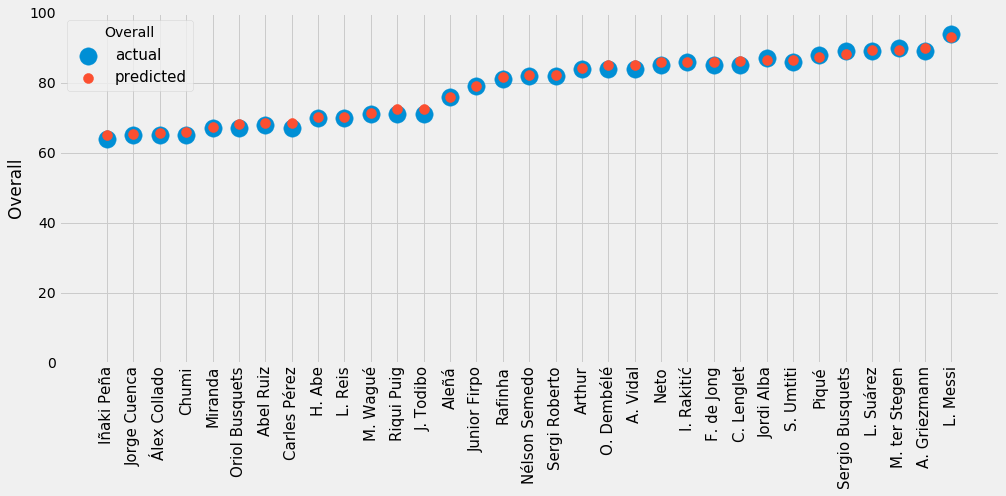

In [33]:
# plot barcelona's players overall
barca = df[df['club'] == 'FC Barcelona']
barca = barca.sort_values(by='prediction')
# plot
xticks = np.arange(len(barca))
plt.figure(figsize=(15, 6))
plt.scatter(xticks, barca.overall, label='actual', s=300)
plt.scatter(xticks, barca.prediction, label='predicted', s=100)
plt.ylim(0, 100)
plt.xticks(ticks=xticks, fontsize=15, rotation=90, labels=barca.short_name)
plt.ylabel("Overall")
plt.legend(title='Overall', loc='upper left', fontsize=15)
#plt.title("FC Barcelona Club Players Actual & Predicted Overall (Ascending Order)")
plt.show()

# ==============================================================